In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 74 kB/s 


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
data_path = '/content/drive/MyDrive/HSE/DL/Project/data/features'

Предобработка данных

In [4]:
def encode_labels(data):
    genres = np.unique(data.label)
    d_enc = dict([(x, i) for i, x in enumerate(genres)])
    return np.array([d_enc[x] for x in data.label]), genres

def preprocess(df: pd.Series):
    # Закодируем названия жанров в числа, сохраним словарик для декодирования
    # Так же сохраним названия файлов, чтобы потом суметь отыскать несоответствия
    y, genres = encode_labels(df)
    df = df.drop('label', axis=1)
    filenames = df.filename.to_numpy()
    df = df.drop('filename', axis=1)
    X = df.to_numpy()
    return X, y, genres, filenames

Кастомный split, который делит еще и имена файлов

In [5]:
def my_train_test_split(X, y, filenames, test_size=0.2, seed=42):
    assert X.shape[0] == y.shape[0] == filenames.shape[0]
    np.random.seed = seed
    idx = np.random.permutation(X.shape[0])
    n = int(test_size * X.shape[0])


    X, y, filenames = X[idx], y[idx], filenames[idx]
    X_train, X_test = X[n:], X[:n]
    y_train, y_test = y[n:], y[:n]
    filenames_train, filenames_test = filenames[n:], filenames[:n]
    return X_train, X_test, y_train, y_test, filenames_train, filenames_test

Научимся считать метрики и строить графики
Сначала посчитаем accuracy и средние значения precision и recall. Интересно посмотреть, как выглядят метрики для разных классов. Это может дать информацию какие классы путает классификатор.

Так же учтем возможность простроения confusion matrix

In [6]:
def count_metrics(y_true, y_pred, genres, average='macro', plot=True):
    # average metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average)
    rec = recall_score(y_true, y_pred,  average=average)
    print(f'Average: acc: {acc:.3f} prec: {prec:.3f} rec: {rec:.3f}')

    # mertics per class
    multi_recall = recall_score(y_true, y_pred, average=None)
    multi_precision = precision_score(y_true, y_pred, average=None)
    print('Per class precision, recall')
    for i, (pre, re) in enumerate(zip(multi_precision, multi_recall)):
        print(f'{genres[i]:>10}:  {pre:.3f}  {re:.3f}')
    
    return multi_precision, multi_recall, y_true, y_pred
    # make plots
    # if plot:
    #     _, ax1 = plt.subplots()
    #     plot_metric(ax1, multi_recall, genres, label='recall')
    #     _, ax2 = plt.subplots()
    #     plot_metric(ax2, multi_precision, genres, label='precision')
    #     cm = confusion_matrix(y_true, y_pred)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
    #     disp.plot()
    #     plt.show()


def plot_metric(ax, metric_array, genres, label):
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
    ax.bar(genres, metric_array, 0.35)
    plt.ylim(min(metric_array)-0.05)
    ax.set_ylabel(label)
    ax.set_title(f'multi {label}')
    # ax.legend()


Наши датасеты - csv файлы со статистическими данными для музыкальных композиций

In [7]:
df_30 = pd.read_csv(os.path.join(data_path, 'features_30_sec.csv'))
df_3 = pd.read_csv(os.path.join(data_path, 'features_3_sec.csv'))

# Классификация 30 секундных файлов

In [8]:
X, y, genres, filenames = preprocess(df_30)
seed=42

Жанры:

In [9]:
list(genres)

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [10]:
def just_count_metrics(model, y_true, y_pred, average='macro'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average)
    rec = recall_score(y_true, y_pred,  average=average)

    multi_recall = recall_score(y_true, y_pred, average=None)
    multi_precision = precision_score(y_true, y_pred, average=None)

    return acc, prec, rec, multi_precision, multi_recall

In [11]:
def choose(model: str, seed):
    if model == 'svm':
        return SVC(C=15, random_state=seed, kernel='rbf', degree=5)
    elif model == 'knn':
        return KNeighborsClassifier(n_neighbors=2, weights="distance")
    elif model == 'catboost':
        return CatBoostClassifier(
            custom_loss=['Accuracy'],
            random_seed=42,
            logging_level='Silent',
            loss_function='MultiClass',
            l2_leaf_reg=0.01
        )

In [12]:
def count_all_metrics(model_name: str, seeds):
    accs, precs, recs, multi_precisions, multi_recalls = [], [], [], [], []

    for seed in tqdm(seeds):
        model = choose(model_name, seed)
        X_train, X_test, y_train, y_test\
                = train_test_split(X, y, test_size=0.2, random_state=seed)
        # X_train, X_test, y_train, y_test, _, _\
        #         = my_train_test_split(X, y, filenames, test_size=0.2, seed=seed)
        scaler1 = StandardScaler()
        scaler2 = StandardScaler()
        X_train_norm = scaler1.fit_transform(X_train)
        model.fit(X_train_norm, y_train)
        y_test_pred = model.predict(scaler2.fit_transform(X_test))
        
        acc, prec, rec, multi_precision, multi_recall = just_count_metrics(model, y_test, y_test_pred)
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        multi_precisions.append(multi_precision)
        multi_recalls.append(multi_recall)

    acc_mean = np.mean(accs)
    prec_mean = np.mean(precs)
    rec_mean = np.mean(recs)
    multi_precision_mean = np.mean(np.array(multi_precisions), axis=0)
    multi_recall_mean = np.mean(np.array(multi_recalls), axis=0)

    # print(f'Average: acc: {acc_mean:.3f} prec: {prec_mean:.3f} rec: {rec_mean:.3f}')
    # for i, (pre, re) in enumerate(zip(multi_precision_mean, multi_recall_mean)):
    #     print(f'{genres[i]:>10}:  {pre:.3f}  {re:.3f}')

    return acc_mean, prec_mean, rec_mean, multi_precision_mean, multi_recall_mean

In [13]:
seeds = [1, 10, 42, 100, 1000, 10000]
# seeds = [42]

In [14]:
%%time
metrics = []
models = ['svm', 'knn', 'catboost']

for model_name in models:
    mm = count_all_metrics(model_name, seeds)
    metrics.append(mm)

acc = [x[0] for x in metrics]
prec = [x[1] for x in metrics]
rec = [x[2] for x in metrics]
multi_precision = np.array([x[3] for x in metrics])
multi_recall = np.array([x[4] for x in metrics])

100%|██████████| 6/6 [08:49<00:00, 88.33s/it]

CPU times: user 16min 40s, sys: 4.24 s, total: 16min 44s
Wall time: 8min 50s


In [15]:
print(models)
print(acc)
print(prec)
print(rec)

# print(f'Average: acc: {acc_mean:.3f} prec: {prec_mean:.3f} rec: {rec_mean:.3f}')

['svm', 'knn', 'catboost']
[0.7316666666666666, 0.6758333333333333, 0.7533333333333333]
[0.7364054603271524, 0.692621967526598, 0.7649216364768993]
[0.7370421215490236, 0.6859571867890529, 0.7542025198383668]


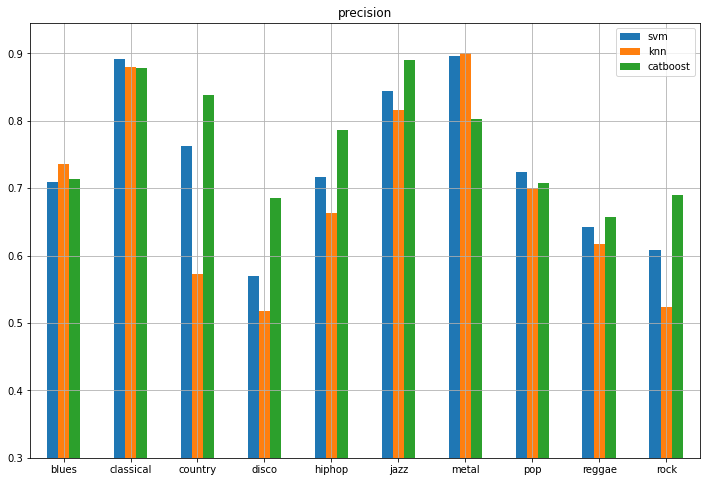

In [18]:
df = pd.DataFrame({model: x for model, x in zip(models, multi_precision)}, index=genres)
ax = df.plot.bar(rot=0, figsize=(12,8), title='precision', grid=True, ylim=0.3)

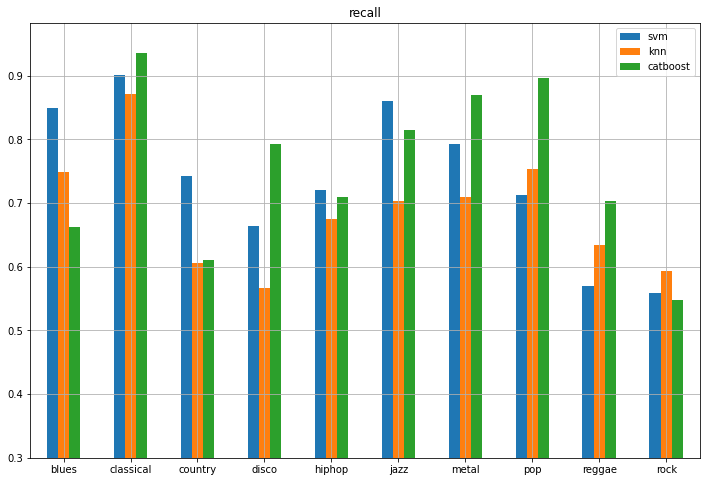

In [19]:
df = pd.DataFrame({model: x for model, x in zip(models, multi_recall)}, index=genres)
ax = df.plot.bar(rot=0, figsize=(12,8), title='recall', grid=True, ylim=0.3)

In [ ]:
%%time

X, y, genres, filenames = preprocess(df_3)
seed=42

metrics = []

for model_name in models:
    mm = count_all_metrics(model_name, seeds)
    metrics.append(mm)

acc = [x[0] for x in metrics]
prec = [x[1] for x in metrics]
rec = [x[2] for x in metrics]
multi_precision = np.array([x[3] for x in metrics])
multi_recall = np.array([x[4] for x in metrics])

100%|██████████| 6/6 [14:12<00:00, 142.08s/it]

CPU times: user 27min 42s, sys: 7.97 s, total: 27min 50s
Wall time: 14min 42s


In [ ]:
print(models)
print(acc)
print(prec)
print(rec)

# print(f'Average: acc: {acc_mean:.3f} prec: {prec_mean:.3f} rec: {rec_mean:.3f}')

['svm', 'knn', 'catboost']
[0.9218385051718384, 0.9144978311644979, 0.9061561561561562]
[0.9215758759582083, 0.9141163027593878, 0.9059592388350652]
[0.9212953875482053, 0.9140405837476173, 0.9058365812766418]


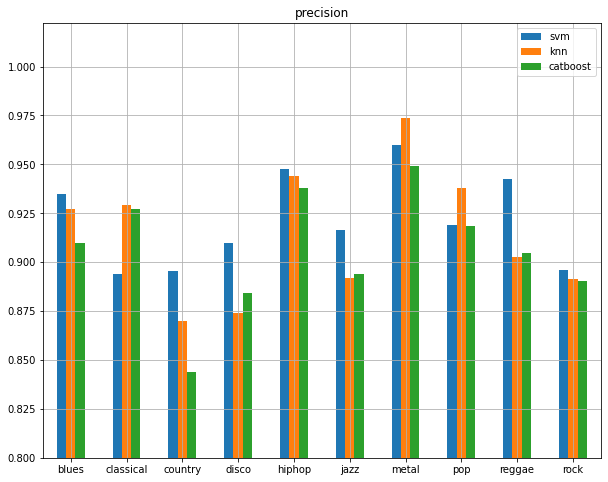

In [ ]:
df = pd.DataFrame({model: x for model, x in zip(models, multi_precision)}, index=genres)
ax = df.plot.bar(rot=0, figsize=(10,8), title='precision', grid=True, ylim=0.8)

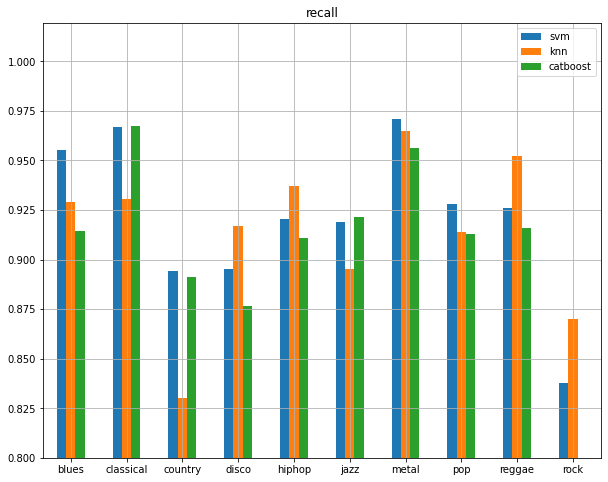

In [ ]:
df = pd.DataFrame({model: x for model, x in zip(models, multi_recall)}, index=genres)
ax = df.plot.bar(rot=0, figsize=(10,8), title='recall', grid=True, ylim=0.8)